# Fraud Detection with GAN and Random Forest

---

## Objective
This notebook addresses class imbalance in fraud detection using:
1. **GANs** to generate synthetic minority class samples.
2. **Random Forest Classifier** to evaluate performance with GAN-augmented data.
3. **Evaluation Metrics** (precision, recall, F1-score) to assess model improvements.

---

## Dataset
- **Source**: 'creditcard.csv'
- **Features**: 'Time', 'Amount', 'V1' to 'V28' (PCA-transformed features).
- **Target ('Class')**:
  - '0': Non-fraudulent
  - '1': Fraudulent

---

## Workflow

1. **Generate Synthetic Data**:
   - Train a GAN to create realistic synthetic samples for the minority class.
   - Combine real and synthetic data to form a balanced dataset.

2. **Baseline Evaluation**:
   - Use Random Oversampling and train a Random Forest classifier.
   - Evaluate performance on the original test set.

3. **Reload Balanced Dataset**:
   - Verify class balance and prepare the data for modeling.


4. **GAN-Augmented Evaluation**:
   - Retrain the Random Forest with the GAN-balanced dataset.
   - Compare metrics against the baseline.

5. **Performance Insights**:
   - Assess the impact of GANs in improving fraud detection.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.over_sampling import RandomOverSampler
from utils import GANDataBalancer

In [2]:
Df=pd.read_csv('creditcard.csv')
Df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
Df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
#missing_Vallues
Df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
# Detect outliers using IQR
outlier_info = {}

for column in Df.columns:
    if column != 'Class':  # Skip the target column (Class)
        Q1 = Df[column].quantile(0.25)
        Q3 = Df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = Df[(Df[column] < lower_bound) | (Df[column] > upper_bound)]
        outlier_info[column] = {
            "outlier_count": outliers.shape[0],
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

# Convert outlier summary to DataFrame
outlier_summary = pd.DataFrame(outlier_info).T
outlier_summary.columns = ['Outlier Count', 'Lower Bound', 'Upper Bound']

print(outlier_summary)

        Outlier Count   Lower Bound    Upper Bound
Time              0.0 -73477.000000  266999.000000
V1             7062.0     -4.274396       4.669664
V2            13526.0     -2.701961       2.907135
V3             3363.0     -3.766705       3.903536
V4            11148.0     -3.236612       3.131313
V5            12295.0     -2.646882       2.567212
V6            22965.0     -2.518586       2.148856
V7             8948.0     -2.240844       2.257204
V8            24134.0     -1.012593       1.131309
V9             8283.0     -2.503452       2.457494
V10            9496.0     -2.019449       1.937947
V11             780.0     -3.015626       2.992725
V12           15348.0     -1.941286       2.153952
V13            3368.0     -2.615106       2.629071
V14           14149.0     -1.803660       1.871236
V15            2894.0     -2.430442       2.496378
V16            8184.0     -1.955036       2.010296
V17            7420.0     -1.808883       1.724810
V18            7533.0     -1.99

In [7]:
target = "Class"
100*Df[target].value_counts()/Df.shape[0]

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [8]:
X = Df.drop(columns=[target])
y = Df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Baseline Evaluation with Random Oversampling

Before implementing GANs to augment the dataset, it is essential to establish a **baseline performance** using a simple and widely-used resampling technique: **Random Oversampling**. 

This step involves:
1. Using **Random Oversampling** to balance the training dataset by duplicating samples from the minority class.
2. Training a **Random Forest Classifier** on the oversampled dataset to predict fraud cases.
3. Evaluating the model's performance on the original, unmodified test set using:
   - **Confusion Matrix**: To analyze prediction outcomes for fraud and non-fraud cases.
   - **Precision, Recall, and F1-Score**: To measure the classifier's effectiveness in detecting fraudulent transactions.

The results obtained here will serve as a benchmark for assessing the **effectiveness of GAN-generated synthetic samples** in improving fraud detection. By comparing the baseline metrics with those achieved using GAN-augmented data, we can quantify the added value of GANs.

In [9]:
# Baseline Evaluation with Random Oversampling
oversampler = RandomOverSampler(sampling_strategy=0.05, random_state=42)  
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42)
model.fit(X_train_oversampled, y_train_oversampled)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
classification_summary = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Summary:")
print(classification_summary)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
[[56860     4]
 [   18    80]]

Classification Summary:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Precision: 0.95
Recall: 0.82
F1 Score: 0.88


In [10]:
# Baseline Evaluation with GAN Oversampling & RandomForest
oversampler = GANDataBalancer(sampling_strategy=0.05, random_state=42, latent_dim=100)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X=X_train, y=y_train)

model = RandomForestClassifier(random_state=42)
model.fit(X_train_oversampled, y_train_oversampled)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
classification_summary = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Summary:")
print(classification_summary)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0/1000 | Discriminator Loss: [array(0.3661954, dtype=float32), array(0.671875, dtype=float32)] | Generator Loss: [array(0.3661954, dtype=float32), array(0.3661954, dtype=float32), array(0.671875, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━

In [12]:
# Baseline Evaluation with Random Oversampling
oversampler = GANDataBalancer(sampling_strategy=0.05, random_state=42, latent_dim=400)  
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X=X_train, y=y_train)

model = RandomForestClassifier(random_state=42)
model.fit(X_train_oversampled, y_train_oversampled)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
classification_summary = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Summary:")
print(classification_summary)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 0/1000 | Discriminator Loss: [array(846.7787, dtype=float32), array(0.28125, dtype=float32)] | Generator Loss: [array(846.7787, dtype=float32), array(846.7787, dtype=float32), array(0.28125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0/1000 | Discriminator Loss: [array(1076.6377, dtype=float32), array(0.2421875, dtype=float32)] | Generator Loss: [array(1076.6377, dtype=float32), array(1076.6377, dtype=float32), array(0.2421875, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
2/2 ━━━━

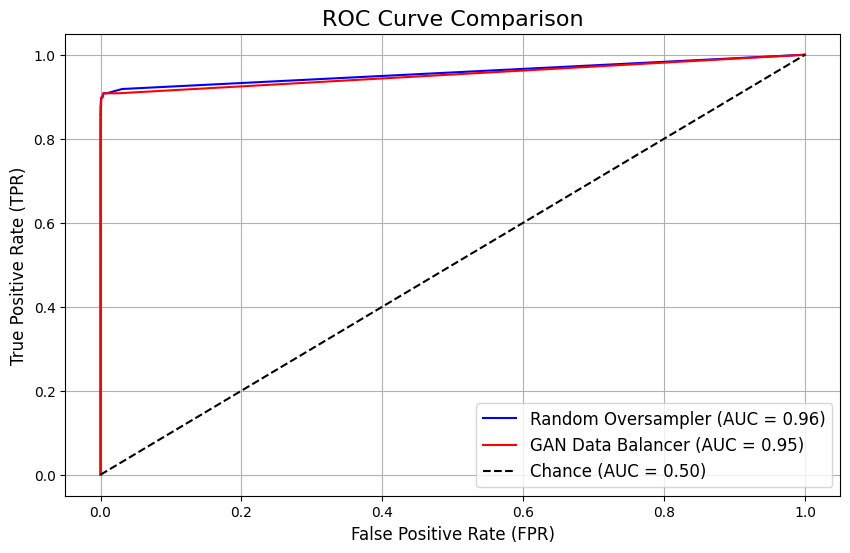

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler  # Ensure this package is installed

# Baseline Evaluation with Random Oversampling
oversampler = RandomOverSampler(sampling_strategy=0.05, random_state=42)
X_train_oversampled_ros, y_train_oversampled_ros = oversampler.fit_resample(X_train, y_train)

ros_model = RandomForestClassifier(random_state=42)
ros_model.fit(X_train_oversampled_ros, y_train_oversampled_ros)

y_pred_proba_ros = ros_model.predict_proba(X_test)[:, 1]
fpr_ros, tpr_ros, _ = roc_curve(y_test, y_pred_proba_ros)
roc_auc_ros = auc(fpr_ros, tpr_ros)

# Evaluation with GAN Data Balancer
gan_oversampler = GANDataBalancer(sampling_strategy=0.05, random_state=42, latent_dim=400)
X_train_oversampled_gan, y_train_oversampled_gan = gan_oversampler.fit_resample(X=X_train, y=y_train)

gan_model = RandomForestClassifier(random_state=42)
gan_model.fit(X_train_oversampled_gan, y_train_oversampled_gan)

y_pred_proba_gan = gan_model.predict_proba(X_test)[:, 1]
fpr_gan, tpr_gan, _ = roc_curve(y_test, y_pred_proba_gan)
roc_auc_gan = auc(fpr_gan, tpr_gan)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_ros, tpr_ros, label=f"Random Oversampler (AUC = {roc_auc_ros:.2f})", color="blue")
plt.plot(fpr_gan, tpr_gan, label=f"GAN Data Balancer (AUC = {roc_auc_gan:.2f})", color="red")
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

plt.title("ROC Curve Comparison", fontsize=16)
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.grid()
plt.show()


**Conclusion:**

Both approaches are performing similarly in terms of accuracy and classifying the majority class well. However, GAN-based data augmentation has a slightly better recall and F1 score, indicating it might be more effective at improving the detection of fraud (minority class).

 It seems like the GAN method can be a good alternative to traditional oversampling for your fraud detection task.